In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
import math


<h1>Dealing With Imbalanced Data</h1>

Take credit card fraud, most transactions are not fraud. A few are, and it is important that those are the ones that we notice. What do we do?

The data here is real, from MasterCard, the weird values is because the data was put through something called PCA before being shared with the public. PCA is a way to reduce the dimensionality (reduce number of features), it also renders the results unrecognizable - here it has been done so that the CC company doesn't share any private stuff. 

In [2]:
df = pd.read_csv("data/creditcard.csv.zip")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Fraud is a 1 in the class value - there is not much fraud! We could be REALLY accurate if we made a dumb model...

0.9982725143693799


<AxesSubplot:xlabel='Class', ylabel='count'>

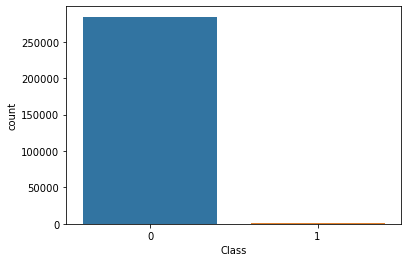

In [4]:
print(len(df[df["Class"]==0])/len(df))
sns.countplot(data=df, x="Class")

If our model just guessed NO every time, we'd be 99.8% accurate - really good, but also useless for the application at hand. 

<br><br>

First, we'll make a model without doing anything, to see the results. 

We won't explore the data a tonne here, but one of the things that we'd probably want to start with would be looking to see if there is a decided difference in the distributions of all the different variables between fraudulent transactions and normal ones. If there are values that are drastically different, those are likely things that are significant in predicting fraud...

We can do a little exercise to generate a sequence of boxplots for each varaible, split by the class. 

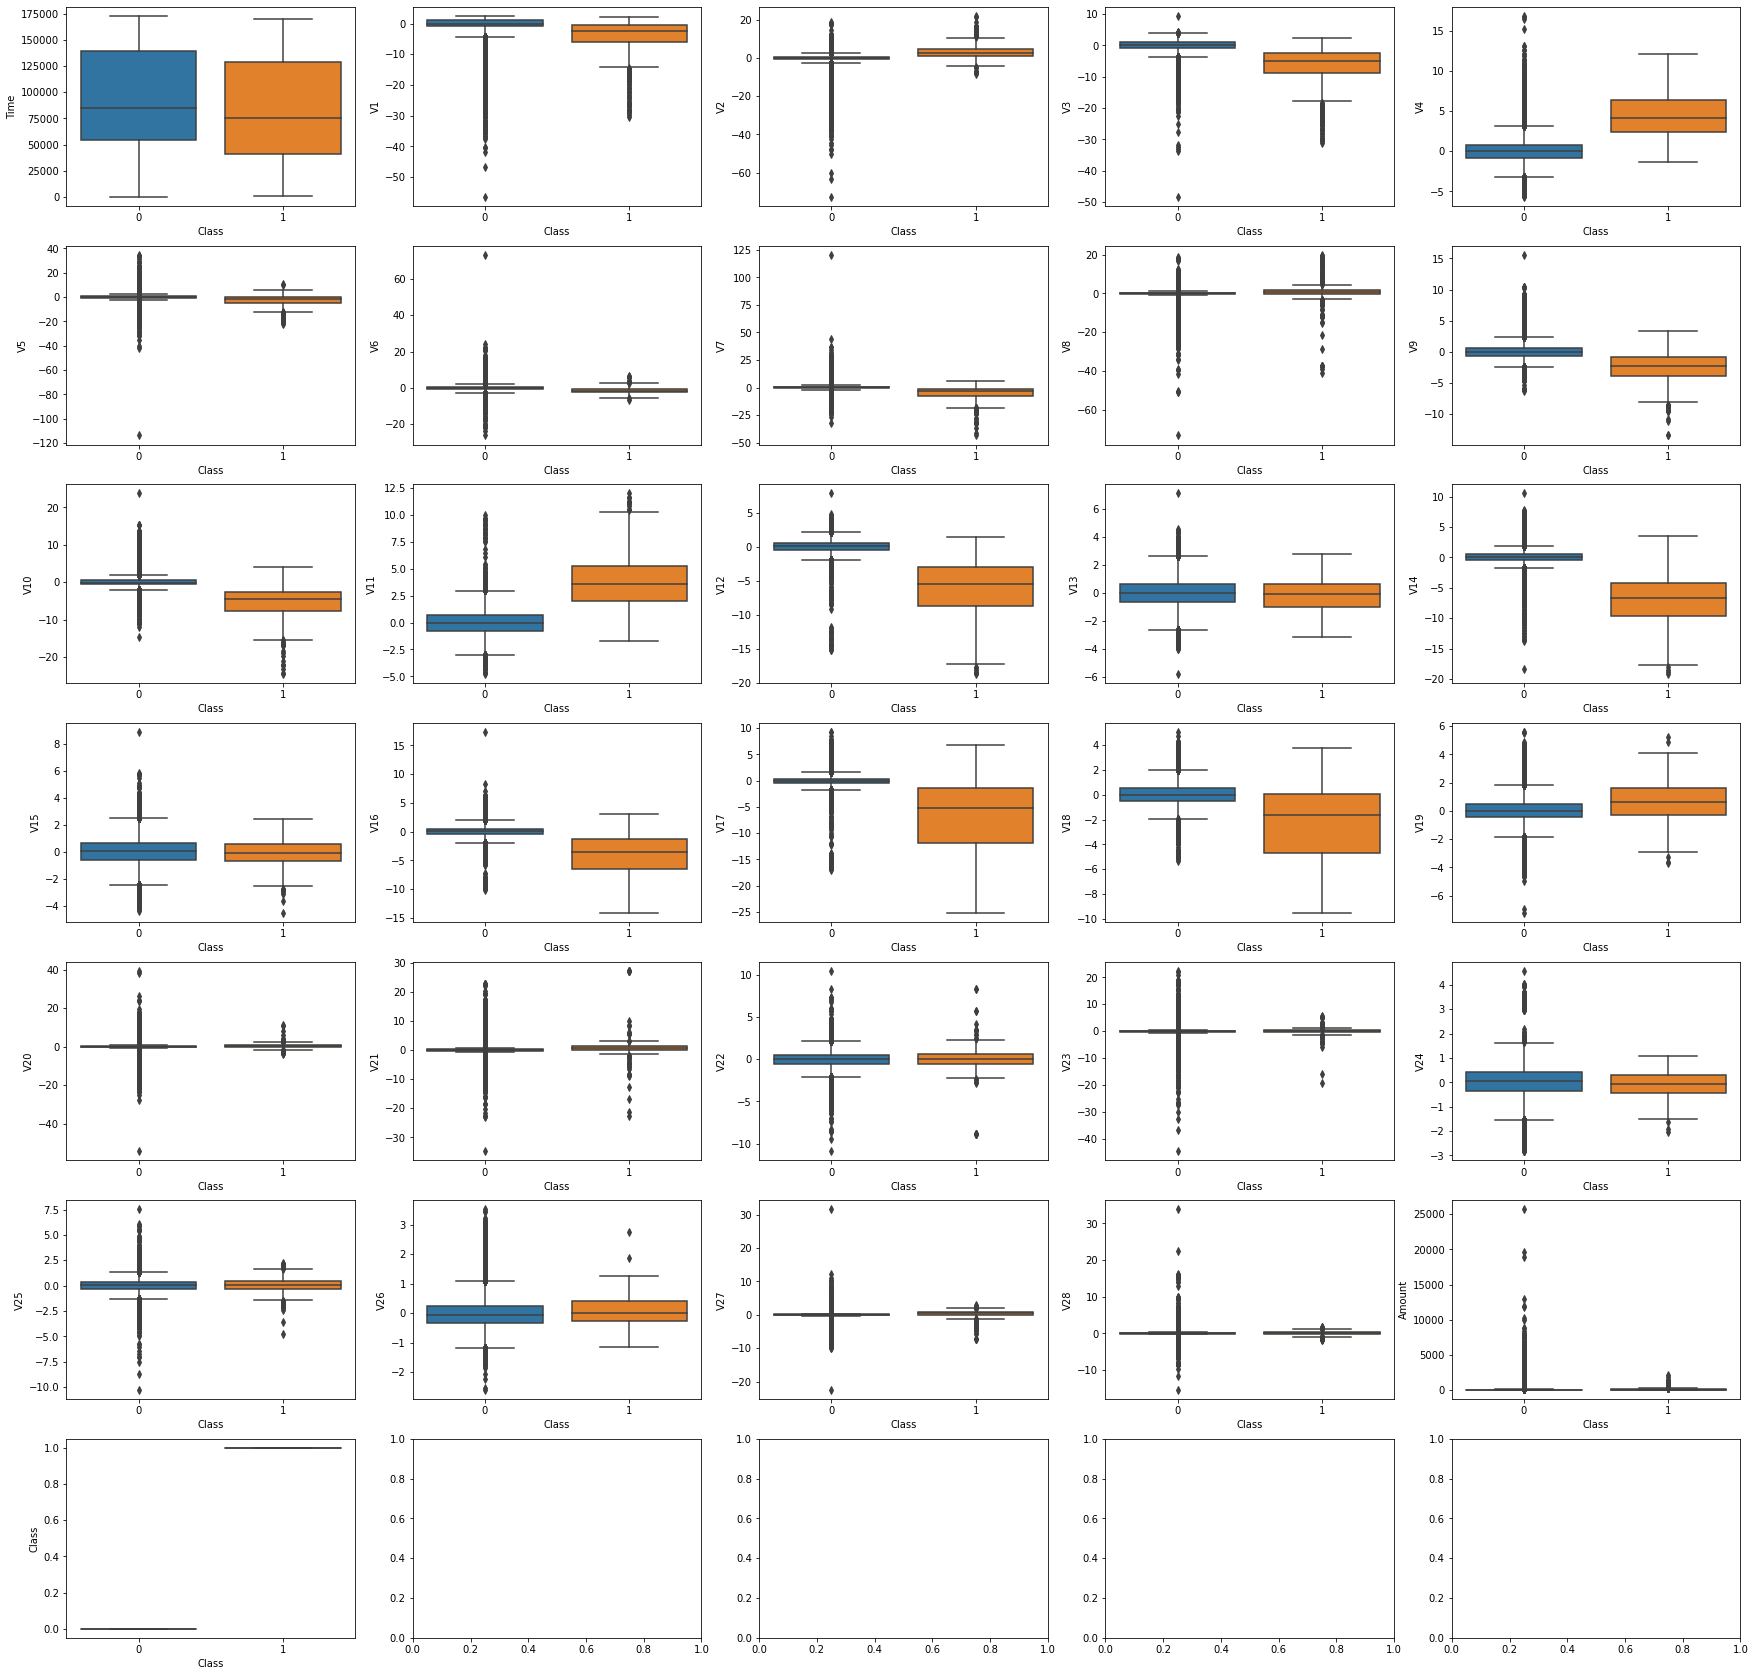

In [5]:
#Visualize differences
feats = df.columns
gCols = 5
gRows = math.ceil(len(feats)/gCols)

f, axes = plt.subplots(ncols=gCols, nrows=gRows, figsize=(30,30))
i = 0
q = 0
for column in df:
    sns.boxplot(x="Class", y=str(column), data=df, ax=axes[q][i])
    i += 1
    if i >= gCols:
        i = 0
        q += 1

Some varaibles, like V13, show very little difference between fraudulent and not fraudulent transactions. Others like V14 seem to show some substantial difference between legit and fraud transactions. We can suspect that those with a difference will likely be our most relevant features in making predictions. 

First, we can builld a basic model, and see what our accuracy is without any maniplation. 

(190820, 30) (190820, 1) (93987, 30) (93987, 1)
F1: 0.6593406593406593
Acc: 0.9990105014523285
Recall: 0.5357142857142857
Precision: 0.8571428571428571


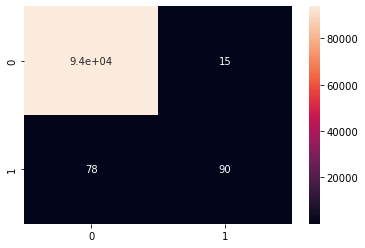

In [6]:
#Build Log Reg model
#Split Data x/y
y1 = np.array(df["Class"]).reshape(-1,1)
x1 = np.array(df.drop(columns={"Class"}))

X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.33)

print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
#Normalize data
scaler = MinMaxScaler()
X_train1_norm = scaler.fit_transform(X_train1)
X_test1_norm = scaler.transform(X_test1)

#Train model
model1 = LogisticRegression().fit(X_train1_norm,y_train1.ravel())

#Make predictions
preds1 = model1.predict(X_test1_norm)

#Generate 1/0 results and show results
labels1 = binarize(np.array(preds1).reshape(-1,1), threshold=.5)
conf_matrix1 = confusion_matrix(y_test1,labels1)
sns.heatmap(conf_matrix1, annot=True)

print("F1:",f1_score(y_test1, labels1))
print("Acc:",accuracy_score(y_test1, labels1))
print("Recall:",recall_score(y_test1, labels1))
print("Precision:",precision_score(y_test1, labels1))

<h3>Simple Model Results</h3>

Overall accuracy is of course high. We do have a bunch of frauds that we are missing, however - we can try to resolve this... hopefully. We are also almost always just guessing "not fraud", which results in high accuracy, but isn't the most useful solution. What we probably want to look at more than the accuracy here is the Recall and the F1. Recall is a metric of how many frauds we are detecting, so we want it to be high. F1 is a balance of recall and precision (how many of the frauds that we detect are real), so this is also a consideration - we don't want to be accusing innocent card holders!

<h2>Undersampling</h2>

The most simple way to approach this is to undersample the not frauds - just leave a bunch out. That one kind of has a downside - we're leaving behind all that potentially valuable data!

We can create a simple undersampler and test it. We will use all the fraudulent data, and randomly select non-fraud data so that we have a balanced number of records on each side. This chops out a bunch of data, but it will give us an equal number of fraud/good, so our dumb approach of always guessing NO won't work with this data. 

(706, 30) (706, 1) (85443, 30) (85443, 1)
F1: 0.33918128654970764
Acc: 0.9947099235747808
Recall: 0.8345323741007195
Precision: 0.21284403669724772


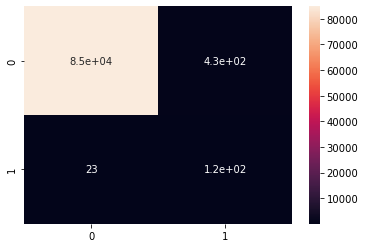

In [8]:
#Undersample
#Split the data into test train
train2, test2 = train_test_split(df, test_size=.3)
#Prep the test data by splitting x/y
y_test2 = np.array(test2["Class"]).reshape(-1,1)
X_test2 = np.array(test2.drop(columns={"Class"}))

#Manually resample the training data
df_NonFrauds = train2[train2["Class"]==0]
df_Frauds = train2[train2["Class"]==1]
df_NF = df_NonFrauds.sample(len(df_Frauds))
df_Under = pd.concat([df_NF, df_Frauds])
y_train2 = np.array(df_Under["Class"]).reshape(-1,1)
X_train2 = np.array(df_Under.drop(columns={"Class"}))
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)
#Normalize data
scaler2 = MinMaxScaler()
X_train2_norm = scaler2.fit_transform(X_train2)
X_test2_norm = scaler2.transform(X_test2) 

#Train model
model2 = LogisticRegression().fit(X_train2_norm,y_train2.ravel())

#Make predictions
preds2 = model2.predict(X_test2_norm)

#Generate 1/0 results and show results
labels2 = binarize(np.array(preds2).reshape(-1,1), threshold=.5)
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Acc:",accuracy_score(y_test2, labels2))
print("Recall:",recall_score(y_test2, labels2))
print("Precision:",precision_score(y_test2, labels2))

<H3>Undersampling Results</h3>

Our overall accuracy is still high, but not very relevant. We have improved our Recall, so we are catching more fraud. on the downside, our precision has fallen, and we are accusing too many people of stealing unfairly! As well, we'd expect very wide variation of results for this - we're plucking out a small percentage of non-frauds and ignoring the rest; random variation will probably be significant from run to run. 

We can probably beat that, at least we hope. We can try to oversample the missing value, or include it more. 

<h2>Oversampling</h2>

Now we can try to oversample, or duplicate the fraudulent examples in the training data until we have a balanced dataset. 

(398052, 30) (398052, 1) (85443, 30) (85443, 1)
F1: 0.12544483985765126
Acc: 0.9769905082920778
Recall: 0.9155844155844156
Precision: 0.0673352435530086


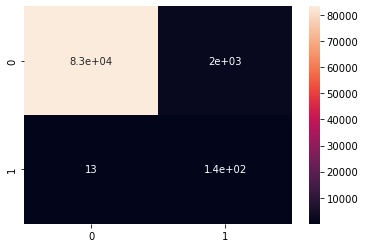

In [9]:
#Oversample
#Split the data into test train
train3, test3 = train_test_split(df, test_size=.3)
#Prep the test data by splitting x/y
y_test3 = np.array(test3["Class"]).reshape(-1,1)
X_test3 = np.array(test3.drop(columns={"Class"}))

#Manually resample the training data
df_NonFrauds = train3[train3["Class"]==0]
df_Frauds = train3[train3["Class"]==1]
df_F = df_Frauds.sample(len(df_NonFrauds), replace=True)
df_Under = pd.concat([df_NonFrauds, df_F])
y_train3 = np.array(df_Under["Class"]).reshape(-1,1)
X_train3 = np.array(df_Under.drop(columns={"Class"}))

print(X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape)
#Normalize data
scaler3 = MinMaxScaler()
X_train3_norm = scaler3.fit_transform(X_train3)
X_test3_norm = scaler3.transform(X_test3) 

#Train model
model3 = LogisticRegression(max_iter=10000).fit(X_train3_norm,y_train3.ravel())

#Make predictions
preds3 = model3.predict(X_test3_norm)

#Generate 1/0 results and show results
labels3 = binarize(np.array(preds3).reshape(-1,1), threshold=.5)
conf_matrix3 = confusion_matrix(y_test3,labels3)
sns.heatmap(conf_matrix3, annot=True)

print("F1:",f1_score(y_test3, labels3))
print("Acc:",accuracy_score(y_test3, labels3))
print("Recall:",recall_score(y_test3, labels3))
print("Precision:",precision_score(y_test3, labels3))

<h3>Oversample Results</h3>

Still not crushing it... Recall is good, but we're again accusing everyone of fraud! Our precision sucks. 

<h2>More Sophisticated Sampling</h2>

If we look at the above, we don't really improve accuracy, in fact we're overall worse than the dumb model. We do get somewhat better on some of the metrics, some of the time, but not really in a way that is excellent. 

We can use some more sophisticated library functions to attempt to make this better. 

<b>Note: you likely need to install the imblearn package. Open a terminal, and type either "pip install imblearn" or "conda install imblearn", one of those should work. You may need to save and reopen this file to force it to update. </b>

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

We can utilize these random over/under samplers to help us out and do what we did above a little bit more easily. 

In the code below there are a whole bunch of different sampling strategies. There are a lot! We have a handful in there that we can try. The over/under sampling ones are just what we did above. The others use some more involved methods to do the sampling. A few that we can try are:
<ul>
<li>SMOTE - Oversampling. Very common. Definition: "SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample as a point along that line."
<li>Tomek Links - Undersampling. Definition: "Tomek Links refers to a method for identifying pairs of nearest neighbors in a dataset that have different classes. Removing one or both of the examples in these pairs (such as the examples in the majority class) has the effect of making the decision boundary in the training dataset less noisy or ambiguous."
<li>ADASYS - Oversampling. Similar to SMOTE but it generates different number of samples depending on an estimate of the local distribution of the class to be oversampled
</ul>

In general, oversampling is more common than undersampling. Common places that we may see it used is in survey types of statistics - when Stats Canada takes a survey of a few thousand people accross Canada, that is likely enough for general estimation. However, if there are demgraphic subgroups that have small numbers, analysis done with the data may oversample them to ensure that they are represented in the data. 

As well, a more cutting edge use is the generation of simulated data for training more complex models - like image recognition with neural networks. A data generation algorithm can use images to generate more synthetic images, which are then fed as training data to a model to learn from.

<h3>Imbalanced Learn Trials</h3>

We can try a few sampling strategies below by just importing and creating those sampling objects. The printed statement will tell us what the balance is. More on each one, and the other options are detailed in the documentation here: https://imbalanced-learn.org/stable/index.html 

Resampled dataset shape Counter({1: 190580, 0: 190488})
F1: 0.2510897994768963
Acc: 0.990860438145701
Recall: 0.9
Precision: 0.1458966565349544


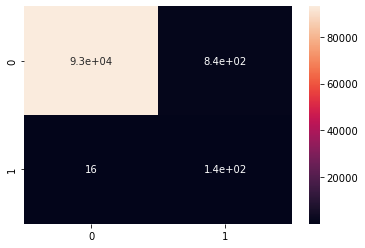

In [13]:
#Do some samplin'
#sampler = RandomOverSampler()
#sampler = RandomUnderSampler()
#sampler = TomekLinks(sampling_strategy='not majority')
#sampler = SMOTE()
sampler = ADASYN()
#sampler = SVMSMOTE()

#Build Log Reg model
#Split Data x/y
y4 = np.array(df["Class"]).reshape(-1,1)
x4 = np.array(df.drop(columns={"Class"}))

X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.33)

#Look at relative imbalance after split
X_train4Samp, y_train4Samp = sampler.fit_resample(X_train4, y_train4)
print('Resampled dataset shape %s' % Counter(y_train4Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train4_norm = scaler.fit_transform(X_train4Samp)
X_test4_norm = scaler.transform(X_test4)

#Train model
model4 = LogisticRegression(max_iter=1000).fit(X_train4_norm,y_train4Samp.ravel())

#Make predictions
preds4 = model4.predict(X_test4_norm)

#Generate 1/0 results and show results
labels4 = binarize(np.array(preds4).reshape(-1,1), threshold=.5)
conf_matrix4 = confusion_matrix(y_test4,labels4)
sns.heatmap(conf_matrix4, annot=True)

print("F1:",f1_score(y_test4, labels4))
print("Acc:",accuracy_score(y_test4, labels4))
print("Recall:",recall_score(y_test4, labels4))
print("Precision:",precision_score(y_test4, labels4))

<h3>And the Results?</h3>

What can we learn from all of this? We were not able to really make things extremely accurate, which sucks!

Some potential issues here:
<ul>
<li>This data may not be well suited to a logistic regression model. 
<li>We may have some features that we need to remove - perhaps there are confounding varaibles. 
<li>We could layer these things together - e.g. use SMOTE then random undersampling. 
</ul>

Just for fun we'll try one with a different type of model and see what we can get. The performance of any indivdual model isn't really super easy to predict in advance - there are some applications that are better suited to some models, but it isn't super determinative. Next semester we'll look at more and more comparisons. 

Below is the same code, but we swapped out Logistic Regression with a Random Forest - which is a tree based algorithm. 

Resampled dataset shape Counter({0: 190491, 1: 190401})
F1: 0.8235294117647058
Acc: 0.9994254524561907
Recall: 0.7730061349693251
Precision: 0.8811188811188811


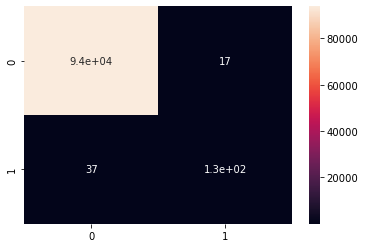

In [14]:
sampler = ADASYN()
#Split Data x/y
y5 = np.array(df["Class"]).reshape(-1,1)
x5 = np.array(df.drop(columns={"Class"}))

X_train5, X_test5, y_train5, y_test5 = train_test_split(x5, y5, test_size=0.33)

#Look at relative imbalance after split
X_train5Samp, y_train5Samp = sampler.fit_resample(X_train5, y_train5)
print('Resampled dataset shape %s' % Counter(y_train5Samp))

#Normalize data
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train5_norm = scaler.fit_transform(X_train5Samp)
X_test5_norm = scaler.transform(X_test5)

#Train model
model5 = RandomForestClassifier().fit(X_train5_norm,y_train5Samp.ravel())
#Make predictions
preds5 = model5.predict(X_test5_norm)

#Generate 1/0 results and show results
labels5 = binarize(np.array(preds5).reshape(-1,1), threshold=.5)
conf_matrix5 = confusion_matrix(y_test5,labels5)
sns.heatmap(conf_matrix5, annot=True)

print("F1:",f1_score(y_test5, labels5))
print("Acc:",accuracy_score(y_test5, labels5))
print("Recall:",recall_score(y_test5, labels5))
print("Precision:",precision_score(y_test5, labels5))

<h1>Finally!!!</h1>

Of all the things we tested, only swapping to a different algorithm really gave results that are bang on! Note that the raw accuracy isn't really different from the first try, but the other considerations for accuracy are better!

<h2>Exercise - Try it With Insurance Data</h2>

The value Response is the goal, and it is also not balanced. 

In [15]:
df2 = pd.read_csv("data/aug_train.csv.zip")
df2.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


<AxesSubplot:xlabel='Response', ylabel='count'>

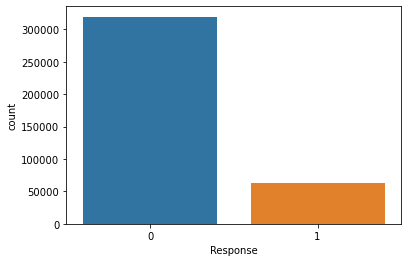

In [16]:
sns.countplot(data=df2, x="Response")